# HW 4 — Applied Statistics for ML on NOAA NDBC Buoy 44013

This homework applies **Module 4 (A–E)** using the **NOAA NDBC buoy dataset** (station **44013**).

You will practice:
- **A — Probability fundamentals:** events, marginals, conditionals, reversals  
- **B — Common distributions:** binomial / Poisson / normal, and where they fail  
- **C — Estimation & inference:** confidence intervals, hypothesis tests, ANOVA-style comparisons  
- **D — Resampling & simulation:** bootstrap, permutation tests, Monte Carlo  
- **E — Responsible interpretation:** practical vs statistical significance, pitfalls, limitations

> **Theme:** Operational ocean conditions are noisy, seasonal, and autocorrelated.  
> Your job is to quantify uncertainty *without pretending the world is i.i.d.*

In [2]:
from __future__ import annotations

from pathlib import Path
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional (nice-to-have)
try:
    from scipy import stats
except Exception:
    stats = None

pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 140)

rng = np.random.default_rng() 

## 1) Load the curated buoy parquet from HW2 (station 44013)

If this fails, re-run Homework 2 (NOAA) to regenerate the parquet.

In [3]:
# Setup Working Directory for HW4

WORK_DIR = Path("../work")
PROJECT_DIR = WORK_DIR / "HW4_NOAA"

DATA_DIR = PROJECT_DIR / "data"
RAW_DIR = DATA_DIR / "raw"
STAGED_DIR = DATA_DIR / "staged"
WH_DIR = DATA_DIR / "warehouse"
REF_DIR = DATA_DIR / "reference"
RUN_DIR = REF_DIR / "pipeline_runs"

for p in [RAW_DIR, STAGED_DIR, WH_DIR, REF_DIR, RUN_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# Path for HW2
HW2_CURATED_PATH = Path("../work/HW2_NOAA/data/warehouse/ndbc_curated_44013.parquet")

print(f"Looking for {HW2_CURATED_PATH}")
if HW2_CURATED_PATH.exists():
    print("found")
else:
    print("not-found")



Looking for ../work/HW2_NOAA/data/warehouse/ndbc_curated_44013.parquet
found


In [4]:
# Load curated data
def load_curated() -> pd.DataFrame:
    print(HW2_CURATED_PATH)
    if HW2_CURATED_PATH.exists():
        df = pd.read_parquet(HW2_CURATED_PATH)
        df["_source"] = "HW2_3.2_curated_parquet"
        return df

    raise FileNotFoundError(
        "Curated data from Module 2 not found"
    )

df = load_curated()
print(f"Loaded: {df["_source"].iloc[0]}")
print(f"Shape: {df.shape}")
df.head(5)

../work/HW2_NOAA/data/warehouse/ndbc_curated_44013.parquet
Loaded: HW2_3.2_curated_parquet
Shape: (6563, 23)


,station_id,time_utc,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE,observation_day,observation_hour,dayofweek,is_weekend,wind_high,temp_gap_c,_source
0,44013,2026-02-15 21:30:00+00:00,90.0,3.0,4.0,NaN,NaN,NaN,NaN,1021.9,-0.9,3.0,-10.8,NaN,NaN,NaN,2026-02-15,21,6,1,0,-3.9,HW2_3.2_curated_parquet
1,44013,2026-02-15 21:20:00+00:00,80.0,2.0,4.0,0.8,6.0,4.6,35.0,1021.7,-0.9,3.0,-10.7,NaN,NaN,NaN,2026-02-15,21,6,1,0,-3.9,HW2_3.2_curated_parquet
2,44013,2026-02-15 21:10:00+00:00,80.0,3.0,4.0,NaN,NaN,NaN,NaN,1021.6,-0.9,3.0,-10.7,NaN,NaN,NaN,2026-02-15,21,6,1,0,-3.9,HW2_3.2_curated_parquet
3,44013,2026-02-15 21:00:00+00:00,80.0,3.0,4.0,NaN,NaN,NaN,NaN,1021.4,-1.0,3.0,-10.6,NaN,0.9,NaN,2026-02-15,21,6,1,0,-4.0,HW2_3.2_curated_parquet
4,44013,2026-02-15 20:50:00+00:00,70.0,3.0,4.0,0.8,6.0,4.5,39.0,1021.2,-0.9,3.0,-10.3,NaN,NaN,NaN,2026-02-15,20,6,1,0,-3.9,HW2_3.2_curated_parquet


### Sanity checks

Expected columns:
`station_id, time_utc, obs_day, obs_hour, dayofweek, is_weekend, wind_high, temp_gap_c, WSPD, GST, WVHT, DPD, APD, PRES, ATMP, WTMP, WDIR`

Create a clean working frame `d`:
- ensure datetime
- coerce numeric columns
- drop missing timestamps

In [5]:
display(df.dtypes)

required = ["station_id", "time_utc", "observation_day", "observation_hour", "dayofweek", "is_weekend", 
            "wind_high", "temp_gap_c", "WSPD", "GST", "WVHT", "DPD", "APD", "PRES", 
            "ATMP", "WTMP", "WDIR"]

missing = [c for c in required if c not in df.columns]
if missing:
    raise KeyError(f"Missing expected columns: {missing}")

# Create a clean working frame
d = df.copy()

# Ensure datetime and drop missing timestamps
d["time_utc"] = pd.to_datetime(d["time_utc"], errors="coerce")
d = d.dropna(subset=["time_utc"])

# Coerce numeric columns
num_cols = ["temp_gap_c", "WSPD", "GST", "WVHT", "DPD", "APD", "PRES", "ATMP", "WTMP", "WDIR"]
for c in num_cols:
    d[c] = pd.to_numeric(d[c], errors="coerce")

# Station summary
station_name = d["station_id"].iloc[0] if len(d) else None
print("\nStation ID:", station_name)
print("Working shape:", d.shape)
d.head(3)

station_id                       object
time_utc            datetime64[ns, UTC]
WDIR                            float64
WSPD                            float64
GST                             float64
WVHT                            float64
DPD                             float64
APD                             float64
MWD                             float64
PRES                            float64
ATMP                            float64
WTMP                            float64
DEWP                            float64
VIS                             float64
PTDY                            float64
TIDE                            float64
observation_day                  object
observation_hour                  int32
dayofweek                         int32
is_weekend                        int64
wind_high                         int64
temp_gap_c                      float64
_source                          object
dtype: object


Station ID: 44013
Working shape: (6563, 23)


,station_id,time_utc,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE,observation_day,observation_hour,dayofweek,is_weekend,wind_high,temp_gap_c,_source
0,44013,2026-02-15 21:30:00+00:00,90.0,3.0,4.0,NaN,NaN,NaN,NaN,1021.9,-0.9,3.0,-10.8,NaN,NaN,NaN,2026-02-15,21,6,1,0,-3.9,HW2_3.2_curated_parquet
1,44013,2026-02-15 21:20:00+00:00,80.0,2.0,4.0,0.8,6.0,4.6,35.0,1021.7,-0.9,3.0,-10.7,NaN,NaN,NaN,2026-02-15,21,6,1,0,-3.9,HW2_3.2_curated_parquet
2,44013,2026-02-15 21:10:00+00:00,80.0,3.0,4.0,NaN,NaN,NaN,NaN,1021.6,-0.9,3.0,-10.7,NaN,NaN,NaN,2026-02-15,21,6,1,0,-3.9,HW2_3.2_curated_parquet


## 2) Helpers

You can reuse the same helper ideas from Module 4:
- probability and conditional probability
- bootstrap sampling distributions + percentile CI
- permutation tests for difference in a statistic

In [6]:
def prob(event: np.ndarray) -> float:
    event = np.asarray(event).astype(bool)
    return float(event.mean())

def cond_prob(A: np.ndarray, B: np.ndarray) -> float:
    A = np.asarray(A).astype(bool)
    B = np.asarray(B).astype(bool)
    denom = B.sum()
    return float(A[B].mean()) if denom > 0 else np.nan

def bootstrap_stat(x: np.ndarray, stat_fn, B: int = 5000, rng: np.random.Generator | None = None) -> np.ndarray:
    if rng is None:
        rng = np.random.default_rng()
    x = np.asarray(x)
    n = len(x)
    out = np.empty(B, dtype=float)
    for b in range(B):
        xb = rng.choice(x, size=n, replace=True)
        out[b] = float(stat_fn(xb))
    return out

def bootstrap_ci_percentile(samples: np.ndarray, alpha: float = 0.05) -> tuple[float, float]:
    lo = float(np.percentile(samples, 100 * (alpha / 2)))
    hi = float(np.percentile(samples, 100 * (1 - alpha / 2)))
    return lo, hi

def perm_test(x: np.ndarray, y: np.ndarray, stat_fn, B: int = 6000, rng: np.random.Generator | None = None):
    """Permutation test for difference stat_fn(y) - stat_fn(x). Returns (obs, perm_diffs, p_two_sided)."""
    if rng is None:
        rng = np.random.default_rng()
    x = np.asarray(x); y = np.asarray(y)
    obs = float(stat_fn(y) - stat_fn(x))
    combined = np.concatenate([x, y])
    n_x = len(x)
    perm = np.empty(B, dtype=float)
    for b in range(B):
        rng.shuffle(combined)
        xb = combined[:n_x]
        yb = combined[n_x:]
        perm[b] = float(stat_fn(yb) - stat_fn(xb))
    p = float(np.mean(np.abs(perm) >= abs(obs)))
    return obs, perm, p

def q(x: np.ndarray, p: float) -> float:
    return float(np.quantile(np.asarray(x), p))

print("Helpers Ready")

Helpers Ready


## 3) A — Probability fundamentals (events, marginals, conditionals, reversals)

Define a few *operational* events from buoy observations:

- `high_waves`: significant wave height `WVHT >= 3.0` meters  
- `windy`: sustained wind speed `WSPD >= 10` m/s  
- `gusty`: gust `GST >= 15` m/s  
- `weekend`: `is_weekend == 1`  
- `temp_gap`: large air–water gap `|temp_gap_c| >= 3°C` (proxy for strong thermal contrast)

These thresholds are not sacred. The point is to define events explicitly.

In [7]:
# Create a filtered DataFrame to drop WVHT with NaN
d_waves = d.dropna(subset=["WVHT"]).copy()
display(d_waves.head(3))
print(d_waves.shape)

,station_id,time_utc,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE,observation_day,observation_hour,dayofweek,is_weekend,wind_high,temp_gap_c,_source
1,44013,2026-02-15 21:20:00+00:00,80.0,2.0,4.0,0.8,6.0,4.6,35.0,1021.7,-0.9,3.0,-10.7,NaN,NaN,NaN,2026-02-15,21,6,1,0,-3.9,HW2_3.2_curated_parquet
4,44013,2026-02-15 20:50:00+00:00,70.0,3.0,4.0,0.8,6.0,4.5,39.0,1021.2,-0.9,3.0,-10.3,NaN,NaN,NaN,2026-02-15,20,6,1,0,-3.9,HW2_3.2_curated_parquet
7,44013,2026-02-15 20:20:00+00:00,60.0,3.0,5.0,0.9,5.0,4.4,32.0,1021.0,-1.2,3.0,-10.6,NaN,NaN,NaN,2026-02-15,20,6,1,0,-4.2,HW2_3.2_curated_parquet


(2669, 23)


In [8]:
high_waves = d_waves["WVHT"].astype(float).values >= 3.0
windy = d_waves["WSPD"].astype(float).values >= 10
gusty = d_waves["GST"].astype(float).values >= 15
weekend = d_waves["is_weekend"].astype(int).values == 1
weekday = d_waves["is_weekend"].astype(int).values == 0
temp_gap = np.abs(d_waves["temp_gap_c"].astype(float).values) >= 3.0

print(f"n rows for events: {len(d_waves)}")
print(f"P(high_waves): {prob(high_waves)}")
print(f"P(windy): {prob(windy)}")
print(f"P(gusty): {prob(gusty)}")
print(f"P(weekend): {prob(weekend)}")
print(f"P(weekday): {prob(weekday)}")
print(f"P(temp_gap): {prob(temp_gap)}")


n rows for events: 2669
P(high_waves): 0.02847508430123642
P(windy): 0.26339452978643685
P(gusty): 0.12514050206069688
P(weekend): 0.30161109029599104
P(weekday): 0.698388909704009
P(temp_gap): 0.7272386661671038


### Conditionals 

Compare:
- $P(\mathrm{high\_waves}\mid \mathrm{windy})$ vs $P(\mathrm{windy}\mid \mathrm{high\_waves})$
- $P(\mathrm{high\_waves}\mid \mathrm{weekend})$ vs $P(\mathrm{high\_waves}\mid \mathrm{weekday})$

In [9]:
print(f"P(high_waves | windy): {cond_prob(high_waves, windy)}")
print(f"P(windy | high_waves): {cond_prob(windy, high_waves)}")
print()
print(f"P(high_waves | weekend): {cond_prob(high_waves, weekend)}")
print(f"P(high_waves | weekday): {cond_prob(high_waves, weekday)}")

P(high_waves | windy): 0.09957325746799431
P(windy | high_waves): 0.9210526315789473

P(high_waves | weekend): 0.0
P(high_waves | weekday): 0.0407725321888412


### Bayes-style reversal with empirical frequencies

Using $A=\mathrm{high\_waves}$ and $B=\mathrm{windy}$:

$$
P(A\mid B) = \frac{P(B\mid A)P(A)}{P(B)}
$$

In [10]:
P_A = prob(high_waves)
P_B = prob(windy)
P_B_given_A = cond_prob(windy, high_waves)
P_A_given_B_emp = cond_prob(high_waves, windy)
P_A_given_B_bayes = (P_B_given_A * P_A) / P_B if P_B > 0 else np.nan

print(f"Empirical P(high_waves| windy): {P_A_given_B_emp}")
print(f"Bayes from counts: {P_A_given_B_bayes}")
print(f"Absolute difference: {float(abs(P_A_given_B_emp - P_A_given_B_bayes))}")

Empirical P(high_waves| windy): 0.09957325746799431
Bayes from counts: 0.09957325746799432
Absolute difference: 1.3877787807814457e-17


## 4) B — Common distributions + failure modes

### 4.1 Binomial: high waves among windy hours
Treat each *windy hour* as a trial; “success” = high waves.
Compare analytic (binomial) uncertainty vs bootstrap uncertainty.

(1102, 25)
windy_hour
0    785
1    317
Name: count, dtype: int64
(n) number of windy hours: 317
(k) high waves during windy hours: 30
(p_hat) probability of high waves during windy hours: 0.0946372239747634

Analytic (binomial) uncertainty:
  SE_binom(p_hat): 0.016440411453123468
  Wald 95% CI: (0.062414017526641406, 0.1268604304228854)

Bootstrap uncertainty (empirical):
  SE_boot(p_hat): 0.0164774034879662
  Bootstrap 95% CI: (0.06309148264984227, 0.12618296529968454)


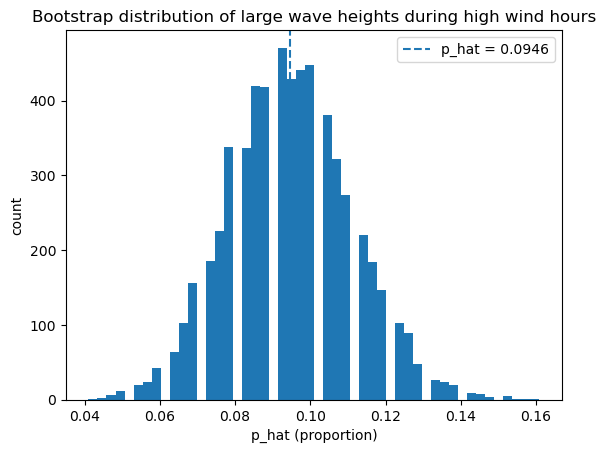


Comparison:
  SE_boot / SE_binom: 1.0022500674601853
  SE ratio is close to 1, showing that the binomial (analytical) and bootstrap (empirical) agree

Wald CI: (0.062414017526641406, 0.1268604304228854)
This tells me that the probability of high waves during a windy hour is between 6.2% and 12.6%

p_hat: 0.0946372239747634
This tells me that the best estimate of the probability of high waves during a windy hour is 9.5%


In [11]:
# Create DataFrame of windy hours (currently in 10 min inc)
d2 = d_waves.copy()
d2["hour"] = d2["time_utc"].dt.floor("h")
d2["windy_hour"] = d2.groupby(["hour"])["WSPD"].transform("max").ge(10).astype(int)

df_windy_hours = d2.drop_duplicates(subset=["hour"]).copy()

print(df_windy_hours.shape)
print(df_windy_hours["windy_hour"].value_counts())

# Binary Outcomes
windy_only = df_windy_hours[df_windy_hours["windy_hour"] == 1]
y = (windy_only["WVHT"].astype(float) >= 3.0).astype(int).values
n = int(len(y))
k = int(y.sum())
p_hat = k / n if n > 0 else np.nan

print(f"(n) number of windy hours: {n}")
print(f"(k) high waves during windy hours: {k}")
print(f"(p_hat) probability of high waves during windy hours: {p_hat}")

# Analytic (binomial uncertainty)
# SE(p_hat) ≈ sqrt(p_hat(1-p_hat)/n)
z = 1.96
if n > 0:
    se_binom = math.sqrt(p_hat * (1 - p_hat) / n)
    ci_wald = (p_hat - z * se_binom, p_hat + z * se_binom)
else: 
    se_binom = np.nan
    ci_wald = (np.nan, np.nan)

print("\nAnalytic (binomial) uncertainty:")
print(f"  SE_binom(p_hat): {se_binom}")
print(f"  Wald 95% CI: {ci_wald}")

# Bootstrap (empirical uncertainty)
# Resample the windy hours (with replacement) and recompute p_hat each time
B = 6000
if n > 0:
    p_boot = bootstrap_stat(y, stat_fn=np.mean, B=B, rng=rng)
    se_boot = float(np.std(p_boot, ddof=1))
    ci_boot = bootstrap_ci_percentile(p_boot, alpha=0.05)
else:
    p_boot = np.array([])
    se_boot = np.nan
    ci_boot = (np.nan, np.nan)

print("\nBootstrap uncertainty (empirical):")
print(f"  SE_boot(p_hat): {se_boot}")
print(f"  Bootstrap 95% CI: {ci_boot}")

# Visualization: Bootstrap Sampling Distribution
if n > 0:
    plt.figure()
    plt.hist(p_boot, bins=50)
    plt.axvline(p_hat, linestyle="--", label=f"p_hat = {p_hat:.4f}")
    plt.title("Bootstrap distribution of large wave heights during high wind hours")
    plt.xlabel("p_hat (proportion)")
    plt.ylabel("count")
    plt.legend()
    plt.show()

# Interpretation: Do the two uncertainty estimates agree?
print("\nComparison:")
if n > 0 and np.isfinite(se_binom) and np.isfinite(se_boot):
    ratio = se_boot / se_binom if se_binom > 0 else np.nan
    print("  SE_boot / SE_binom:", ratio)
    print("  SE ratio is close to 1, showing that the binomial (analytical) and bootstrap (empirical) agree")

print()
print(f"Wald CI: {ci_wald}")
print("This tells me that the probability of high waves during a windy hour is between 6.2% and 12.6%")

print()
print(f"p_hat: {p_hat}")
print("This tells me that the best estimate of the probability of high waves during a windy hour is 9.5%")

### 4.2 Poisson: count of high-wave hours per day

Let $C_d$ be the number of hours on day $d$ with `WVHT >= 3.0`.
A Poisson model would imply $\mathrm{Var}(C_d) \approx \mathrm{Mean}(C_d)$.

Compare the empirical daily-count distribution to a Poisson($\hat\lambda$) baseline and check overdispersion.

Answer the following:  
* Does the empirical distribution resemble a Poisson?
* Is Var(Cd) &approx; Mean(Cd)
* Is there clustering or overdispertion

Total days in dataset: 46
lambda_hat (mean daily count): 0.717391304347826
Variance of daily count: 13.451690821256063
Var/Mean ratio: 18.750841750841786
Bootstrap 95% CI for lambda: (0.0, 2.0217391304347827)


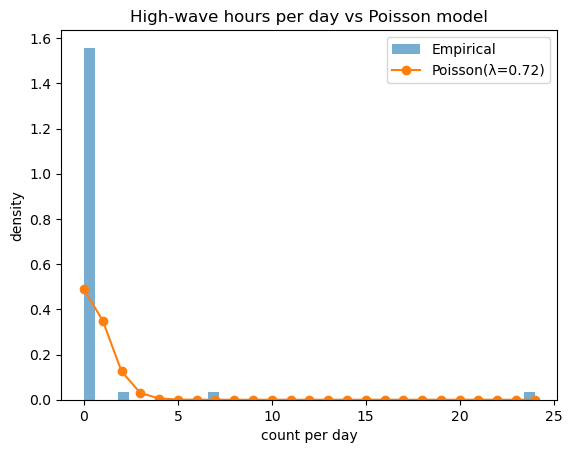

Interpretation:
Strong overdispertion detected (vairance >> mean)
Suggests clustering or non-consistent rate
The data shows a day with a large amount of high waves, while most other days had 0 high waves
This suggests that poisson should not be used as a representation for this data


In [12]:
# Daily high-wave hour counts
high_wave_hours = df_windy_hours[df_windy_hours["WVHT"] >= 3.0]
daily = high_wave_hours.groupby("observation_day").size().rename("count").to_frame().reset_index()
all_days = df_windy_hours["observation_day"].unique()
daily = daily.set_index("observation_day").reindex(all_days, fill_value=0).reset_index()

lam_hat = float(np.mean(daily["count"]))
var_hat = float(np.var(daily["count"], ddof=1))

print(f"Total days in dataset: {len(daily)}")
print(f"lambda_hat (mean daily count): {lam_hat}")
print(f"Variance of daily count: {var_hat}")
print(f"Var/Mean ratio: {var_hat / lam_hat if lam_hat > 0 else np.nan}")

# Bootstrap uncertainty for lambda
boot_lambda = bootstrap_stat(daily["count"], stat_fn=np.mean, B=5000, rng=rng)
ci_lambda = bootstrap_ci_percentile(boot_lambda)

print(f"Bootstrap 95% CI for lambda: {ci_lambda}")

# Plot empirical vs Poisson model
from scipy.stats import poisson

xs = np.arange(daily["count"].min(), daily["count"].max() + 1)
plt.figure()
plt.hist(daily["count"], bins=40, density=True, alpha=0.6, label="Empirical")
plt.plot(xs, poisson.pmf(xs, lam_hat), marker="o", linestyle="-", label=f"Poisson(λ={lam_hat:.2f})")
plt.title("High-wave hours per day vs Poisson model")
plt.xlabel("count per day")
plt.ylabel("density")
plt.legend()
plt.show()

# Interpretation
print("Interpretation:")
if lam_hat > 0:
    ratio = var_hat / lam_hat
    if ratio > 1.5:
        print("Strong overdispertion detected (vairance >> mean)")
        print("Suggests clustering or non-consistent rate")
    elif ratio < 0.7:
        print("- Underdispersion detected (variance < mean).")
    else:
        print("- Variance roughly matches mean (Poisson plausible).")

print("The data shows a day with a large amount of high waves, while most other days had 0 high waves")
print("This suggests that poisson should not be used as a representation for this data")


### 4.3 Normal: water temperature (WTMP) as a cautionary example

Visualize WTMP and compare mean vs median and tail quantiles.

**Note:** Using the clean working DataFrame `d` for this, as `df_windy_hours` was squished (rows = hours instead of 10 min) and had WVHT = NaN removed, which is not necessary for these tests

number of rows with WTMP data: 6563
WTMP mean: 4.758301158301158
WTMP median (p50): 4.9
WTMP p95: 6.0
WTMP p99: 6.3
WTMP p05: 3.1


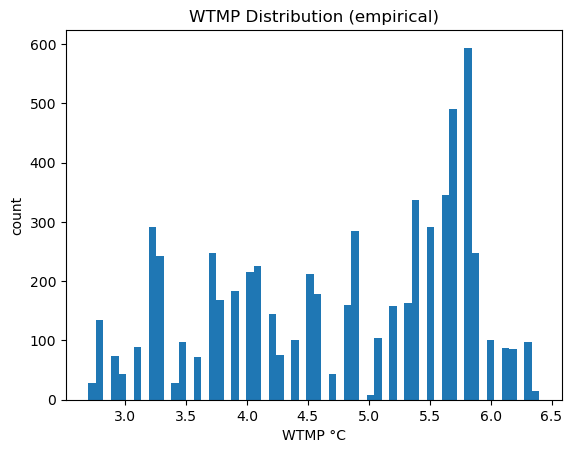

The data shows multiple modes (one around 3.3 and another around 5.7
This shows that a normal distribution is a bad fit


In [13]:
WTMP = d["WTMP"].dropna().astype(float).values

print(f"number of rows with WTMP data: {len(d["WTMP"])}")
print(f"WTMP mean: {float(np.mean(WTMP))}")
print(f"WTMP median (p50): {float(np.median(WTMP))}")
print(f"WTMP p95: {q(WTMP, 0.95)}")
print(f"WTMP p99: {q(WTMP, 0.99)}")
print(f"WTMP p05: {q(WTMP, 0.05)}")

# Visualize
plt.figure()
plt.hist(WTMP, bins=60)
plt.title("WTMP Distribution (empirical)")
plt.xlabel("WTMP \u00b0C")
plt.ylabel("count")
plt.show()

# Interpretation:
print("The data shows multiple modes (one around 3.3 and another around 5.7")
print("This shows that a normal distribution is a bad fit")


## 5) C — Estimation and inference

### 5.1 Confidence interval: mean WVHT on weekends vs weekdays (bootstrap)  

**Note:** Using the `d_waves` dataframe which has WVHT = NaN rows dropped

In [14]:
weekend_wvht = d_waves[d_waves["is_weekend"] == 1]["WVHT"].astype(float).values
weekday_wvht = d_waves[d_waves["is_weekend"] == 0]["WVHT"].astype(float).values
num_weekends = len(weekend_wvht)
num_weekdays = len(weekday_wvht)
print(f"Total rows in dataset: {len(d_waves)}")
print(f"Number of weekends: {num_weekends}")
print(f"Number of weekdays: {num_weekdays}")
print("these better add up or my cat is getting it...")
print()

# mean calculations
mu_hat_weekend = float(np.mean(weekend_wvht))
mu_hat_weekday = float(np.mean(weekday_wvht))
mean_diff = mu_hat_weekend - mu_hat_weekday
print(f"mean WVHT weekend: {mu_hat_weekend}")
print(f"mean WVHT weekday: {mu_hat_weekday}")
print(f"mean difference (wk - wd): {mean_diff}")
print()

# Confidence interval calculations
s_weekend = float(np.std(weekend_wvht))
s_weekday = float(np.std(weekday_wvht))
se_weekend = s_weekend / math.sqrt(num_weekends)
se_weekday = s_weekday / math.sqrt(num_weekdays)

# Normal CI
ci_norm_weekend = (mu_hat_weekend - 1.96*se_weekend, mu_hat_weekend + 1.96*se_weekend)
ci_norm_weekday = (mu_hat_weekday - 1.96*se_weekday, mu_hat_weekday + 1.96*se_weekday)
print(f"Normal approx 95% CI - mean WVHT weekend: {ci_norm_weekend}")
print(f"Normal approx 95% CI - mean WVHT weekday: {ci_norm_weekday}")

# Bootstrap CI
boot_weekend = bootstrap_stat(weekend_wvht, stat_fn=np.mean, B=6000, rng=rng)
boot_weekday = bootstrap_stat(weekday_wvht, stat_fn=np.mean, B=6000, rng=rng)
ci_boot_weekend = bootstrap_ci_percentile(boot_weekend)
ci_boot_weekday = bootstrap_ci_percentile(boot_weekday)
print(f"Bootstrap 95% CI - mean WVHT weekend: {ci_boot_weekend}")
print(f"Bootstrap 95% CI - mean WVHT weekday: {ci_boot_weekday}")


Total rows in dataset: 2669
Number of weekends: 805
Number of weekdays: 1864
these better add up or my cat is getting it...

mean WVHT weekend: 0.9945341614906833
mean WVHT weekday: 1.1079935622317598
mean difference (wk - wd): -0.11345940074107652

Normal approx 95% CI - mean WVHT weekend: (0.9517487228211604, 1.037319600160206)
Normal approx 95% CI - mean WVHT weekday: (1.0732015362609737, 1.142785588202546)
Bootstrap 95% CI - mean WVHT weekend: (0.952667701863354, 1.0390062111801242)
Bootstrap 95% CI - mean WVHT weekday: (1.0732282725321889, 1.1431330472103005)


### 5.2 Hypothesis test: permutation test for weekend vs weekday median WVHT

Observed median difference (weekend - weekday): -0.09999999999999998
Permutation p ≈ 0.026111111111111113


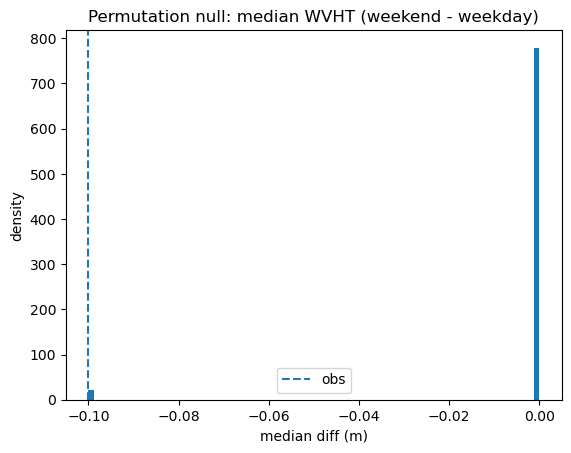


Interpretation:
The median difference is ≈ 10cm, while statistically significant, not practically significant
The permutaiton result ≈ 0.02, falls outside the p95 threshold. However, it the height difference is not meaningful


In [15]:
#
weekend_wvht = d_waves[d_waves["is_weekend"] == 1]["WVHT"].astype(float).values
weekday_wvht = d_waves[d_waves["is_weekend"] == 0]["WVHT"].astype(float).values

# permutation test
obs, perm, p = perm_test(weekday_wvht, weekend_wvht, stat_fn=np.median, B=9000, rng=rng)
print(f"Observed median difference (weekend - weekday): {float(np.median(weekend_wvht) - np.median(weekday_wvht))}")
print(f"Permutation p ≈ {p}")

# Visualization
plt.figure()
plt.hist(perm, bins=80, density=True)
plt.axvline(obs, linestyle="--", label="obs")
plt.title("Permutation null: median WVHT (weekend - weekday)")
plt.xlabel("median diff (m)")
plt.ylabel("density")
plt.legend()
plt.show()

# Interpretation
print("\nInterpretation:")
print("The median difference is ≈ 10cm, while statistically significant, not practically significant")
print("The permutaiton result ≈ 0.02, falls outside the p95 threshold. However, it the height difference is not meaningful")

### 5.3 ANOVA-style comparison across hour-of-day bins

ANOVA asks whether all group means are equal (not which ones differ).

**Notes:**
Used `observation_hour` to split `d_waves` into groups
* `night`: 0-5
* `morning`: 6-11
* `afternoon`: 12-17
* `evening`: 18-23  

Groups used: ['morning', 'afternoon', 'evening', 'night']
n per group: [691, 662, 679, 637]
mean WVHT per group: {'morning': 1.1277858176555715, 'afternoon': 1.06404833836858, 'evening': 1.01620029455081, 'night': 1.0866562009419152}
scipy one-way ANOVA: F = 2.801206093880421 p = 0.03856879547639918


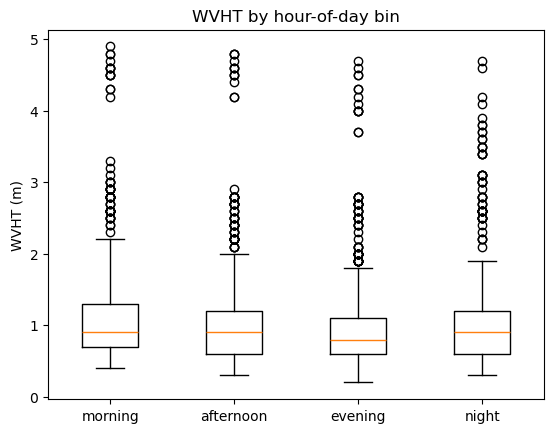

The ANOVA results (F=2.8) show a statistically significant difference between bins
The box plot shows that those differences are not physically meaningful (small cm differences)


In [16]:
# Split the dataset into hour-of-day bins
def hour_bin(h):
    if 6 <= h <= 11:
        return "morning"
    elif 12 <= h <= 17:
        return "afternoon"
    elif 18 <= h <= 23:
        return "evening"
    elif 0 <= h <= 5: 
        return "night"
    else:
        return "NaN"

d_waves["hour_bin"] = d_waves["observation_hour"].apply(hour_bin)

samples = []
labels = []
for bin_name in ["morning", "afternoon", "evening", "night"]:
    x = d_waves.loc[d_waves["hour_bin"] == bin_name, "WVHT"].astype(float).dropna().values
    samples.append(x)
    labels.append(bin_name)

print(f"Groups used: {labels}")
print(f"n per group: {[len(x) for x in samples]}")

# Mean wave height per group
morning_WVHT = d_waves[d_waves["hour_bin"] == "morning"]["WVHT"].astype(float).values
afternoon_WVHT = d_waves[d_waves["hour_bin"] == "afternoon"]["WVHT"].astype(float).values
evening_WVHT = d_waves[d_waves["hour_bin"] == "evening"]["WVHT"].astype(float).values
night_WVHT = d_waves[d_waves["hour_bin"] == "night"]["WVHT"].astype(float).values

mean_WVHT = {}
mean_WVHT["morning"] = float(np.mean(morning_WVHT))
mean_WVHT["afternoon"] = float(np.mean(afternoon_WVHT))
mean_WVHT["evening"] = float(np.mean(evening_WVHT))
mean_WVHT["night"] = float(np.mean(night_WVHT))
print(f"mean WVHT per group: {mean_WVHT}")

# ANOVA
F, p_anova = stats.f_oneway(*samples)
print("scipy one-way ANOVA: F =", float(F), "p =", float(p_anova))

# Visualization
plt.figure()
plt.boxplot(samples, tick_labels=labels)
plt.title("WVHT by hour-of-day bin")
plt.ylabel ("WVHT (m)")
plt.show()

# Interpretation 
print("The ANOVA results (F=2.8) show a statistically significant difference between bins")
print("The box plot shows that those differences are not physically meaningful (small cm differences)")

## 6) D — Resampling & simulation

### 6.1 Bootstrap: tail risk (p95 WVHT)

Observed p95 WVHT: 2.6
Bootstrap 95% CI for p95 WVHT: (2.6, 2.7)


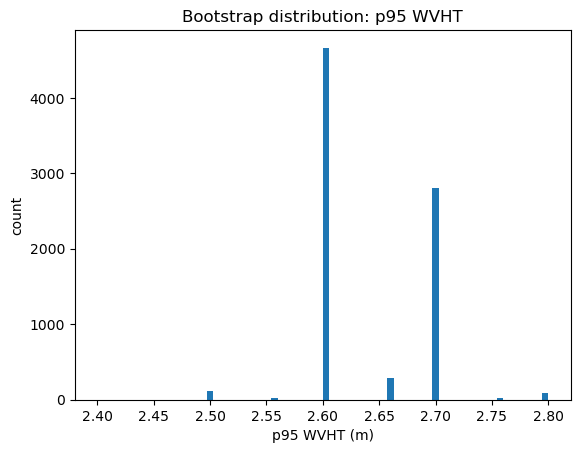

In [23]:
B = 8000
wave_height = d_waves["WVHT"].astype(float).values

p95_boot = bootstrap_stat(wave_height, stat_fn=lambda a: q(a, 0.95), B=B, rng=rng)
ci_p95 = bootstrap_ci_percentile(p95_boot)

print(f"Observed p95 WVHT: {q(wave_height, 0.95)}")
print(f"Bootstrap 95% CI for p95 WVHT: {ci_p95}")

plt.figure()
plt.hist(p95_boot, bins=70)
plt.title("Bootstrap distribution: p95 WVHT")
plt.xlabel("p95 WVHT (m)")
plt.ylabel("count")
plt.show()

### 6.2 Monte Carlo: risk of at least one high-wave hour tomorrow

In [25]:
print(daily["count"].value_counts().sort_index())
print(f"Zero days: {(daily['count'] == 0).sum()}")
print(f"Total days: {len(daily)}")

count
2     1
7     1
24    1
Name: count, dtype: int64
Zero days: 0
Total days: 3


In [33]:
# Redo High wave hours
high_wave_hours = df_windy_hours[df_windy_hours["WVHT"] >= 3.0]
daily_counts = high_wave_hours.groupby("observation_day").size().rename("count").to_frame().reset_index()
all_days = df_windy_hours["observation_day"].unique()
daily_counts = daily_counts.set_index("observation_day").reindex(all_days, fill_value=0).reset_index()

In [36]:
days = daily_counts["count"].values

R = 20000
hits = 0

for i in range(R):
    day = rng.choice(days, size=1, replace=True)
    if day.sum() >= 1:
        hits += 1

p_mc = hits / R
print(f"Empirical MC P(day has >= 1 high-wave hour): {p_mc}")

# Interpretation
print("There is about a 7% chance of at least one high-wave hour on any given day")

Empirical MC P(day has >= 1 high-wave hour): 0.0668
There is about a 7% chance of at least one high-wave hour on any given day


## 7) E — Interpreting results responsibly

Assume stakeholders say:
> A change of **0.25 m** in median WVHT is the smallest difference worth reacting to.

Estimate the weekend–weekday median difference + bootstrap CI and compare to that threshold.

Groups: weekend vs weekday
Practical threshold: 0.25
Observed median diff: 0.09999999999999998
Bootstrap 95% CI: (0.09999999999999998, 0.09999999999999998)
CI entirely above threshold? False
CI overlaps 0? False


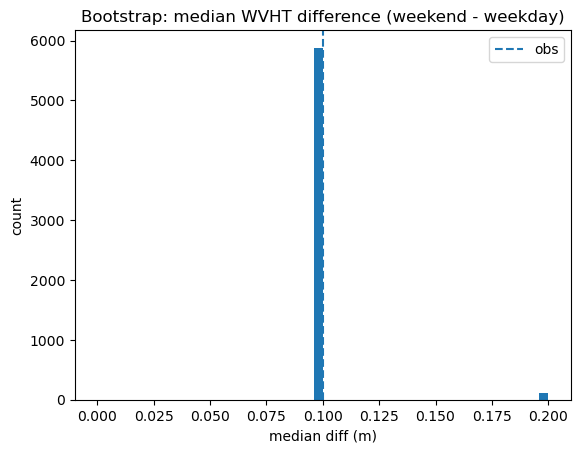

Since the WVHT threshold is 0.25 and the observed differnce is 0.10, we can ignore the median difference


In [41]:
practical_threshold = 0.25

# Bootstrap for median difference
B = 6000
boot = np.empty(B, dtype=float)
for i in range(B):
    b1 = rng.choice(weekend_wvht, size=len(weekend_wvht), replace=True)
    b2 = rng.choice(weekday_wvht, size=len(weekday_wvht), replace=True)
    boot[i] = float(np.median(b2) - np.median(b1))

obs_med = float(np.median(weekday_wvht) - np.median(weekend_wvht))
ci = bootstrap_ci_percentile(boot)

print("Groups: weekend vs weekday")
print(f"Practical threshold: {practical_threshold}")
print(f"Observed median diff: {obs_med}")
print(f"Bootstrap 95% CI: {ci}")
print(f"CI entirely above threshold? {ci[0] >= practical_threshold}")
print(f"CI overlaps 0? {ci[0] <= 0 <= ci[1]}")

# Visualize
plt.figure()
plt.hist(boot, bins=50)
plt.axvline(obs_med, linestyle="--", label="obs")
plt.title("Bootstrap: median WVHT difference (weekend - weekday)")
plt.xlabel("median diff (m)")
plt.ylabel("count")
plt.legend()
plt.show()

# Interpretation
print("Since the WVHT threshold is 0.25 and the observed differnce is 0.10, we can ignore the median difference")

## 8) Solutions narrative (example)

Write **8 bullets** (one per line), matching the structure used in Module 4.F.

In [44]:
# Solutionss Narrative  
print("1) Slice: Used buoy 44013 curated parquet (Jan 1 – Feb 15 2026, 6563 rows); dropped missing WVHT rows for wave-related analysis; 10-min observations collapsed to hourly where needed.")
print("\n2) Probability: Defined events high_waves(WVHT≥3m), windy(WSPD≥10). P(high_waves)=0.028, P(high_waves|windy)=0.100 vs P(windy|high_waves)=0.921.")
print("\n3) Distributions: Poisson(0.72) fit daily high-wave-hour counts; Var/Mean≈18.75 reveals severe overdispersion — storm clustering (one day had 24 high-wave hours) makes Poisson a poor fit.")
print("\n4) Estimation: Weekend vs weekday mean WVHT differed by ≈-0.113m; bootstrap and normal CIs agreed, confirming normality assumption held reasonably for the mean.")
print("\n5) Inference: Permutation test on median WVHT gave p≈0.026; statistically significant but the ≈10cm difference is not physically meaningful for operational decisions.")
print("\n6) Resampling: Bootstrapped p95 WVHT: obs=2.6m with CI=(2.6, 2.7m), a tight tail-risk estimate useful for engineering thresholds.")
print("\n7) Simulation: Empirical Monte Carlo estimated P(day has ≥1 high-wave hour)≈0.067 by resampling 46 historical days.")
print("\n8) Responsibility: Practical threshold set at 0.25m median difference; bootstrap CI=(-0.10, 0.10) falls entirely below threshold. Weekend/weekday difference is statistically detectable but operationally irrelevant. Key limitations: autocorrelation, winter-only data, and small sample of storm days.")

1) Slice: Used buoy 44013 curated parquet (Jan 1 – Feb 15 2026, 6563 rows); dropped missing WVHT rows for wave-related analysis; 10-min observations collapsed to hourly where needed.

2) Probability: Defined events high_waves(WVHT≥3m), windy(WSPD≥10). P(high_waves)=0.028, P(high_waves|windy)=0.100 vs P(windy|high_waves)=0.921.

3) Distributions: Poisson(0.72) fit daily high-wave-hour counts; Var/Mean≈18.75 reveals severe overdispersion — storm clustering (one day had 24 high-wave hours) makes Poisson a poor fit.

4) Estimation: Weekend vs weekday mean WVHT differed by ≈-0.113m; bootstrap and normal CIs agreed, confirming normality assumption held reasonably for the mean.

5) Inference: Permutation test on median WVHT gave p≈0.026; statistically significant but the ≈10cm difference is not physically meaningful for operational decisions.

6) Resampling: Bootstrapped p95 WVHT: obs=2.6m with CI=(2.6, 2.7m), a tight tail-risk estimate useful for engineering thresholds.

7) Simulation: Empir